## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

#os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [10]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

In [17]:
results = {}
loadback = {}
save_best_only = [False, True]
for i in save_best_only:
    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                                 monitor="val_loss", 
                                 save_best_only=i)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = f"patience_value_{i}"
    results[exp_name_tag] = {'train_loss': train_loss,
                            'valid_loss':valid_loss,
                            'train_acc':train_acc,
                            'valid_acc':valid_acc}

    # Load back
    model = keras.models.load_model("./tmp.h5")
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    loadback[exp_name_tag] = {'loss_loadback': loss_loadback, 'acc_loadback': acc_loadback}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
__________

50000/50000 [==============================] - 2s 44us/step - loss: 0.5344 - acc: 0.8480 - val_loss: 1.6387 - val_acc: 0.4986
Epoch 48/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5184 - acc: 0.8531 - val_loss: 1.6541 - val_acc: 0.4980
Epoch 49/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5002 - acc: 0.8608 - val_loss: 1.6446 - val_acc: 0.4991
Epoch 50/50
10000/10000 [==============================] - 1s 109us/step


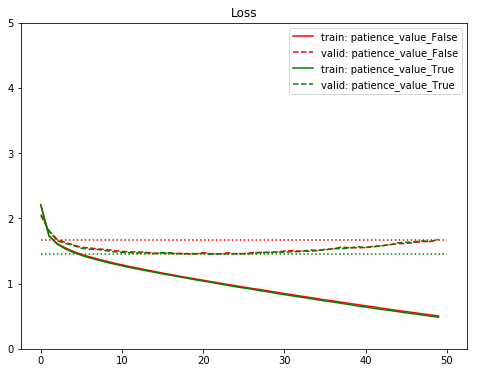

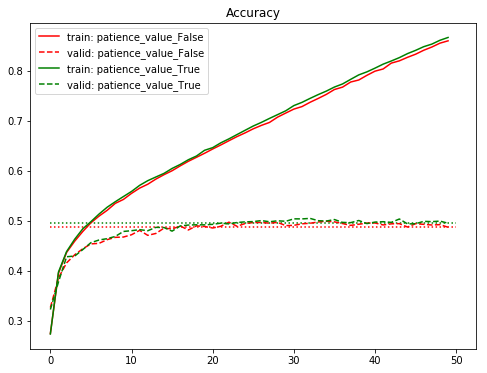

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=f"valid: {cond}", color=color_bar[i])
    plt.hlines(y=loadback[cond]['loss_loadback'], xmin=0, xmax=len(train_loss), colors=color_bar[i], linestyles=':')
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=f"valid: {cond}", color=color_bar[i])
    plt.hlines(y=loadback[cond]['acc_loadback'], xmin=0, xmax=len(train_loss), colors=color_bar[i], linestyles=':')
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
from keras.callbacks import ModelCheckpoint

keras.backend.clear_session()
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(
    lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(
    loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

model_ckpt = ModelCheckpoint(
    filepath="./tmp_weights_only.h5",
    monitor="val_loss",
    save_weights_only=True,
    save_best_only=True)

model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[model_ckpt])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.4894 - acc: 0.8642 - val_loss: 1.7110 - val_acc: 0.4882


In [12]:
keras.backend.clear_session()
model = build_mlp(input_shape=x_train.shape[1:])
model.load_weights("./tmp_weights_only.h5")
model.summary()
model.compile(
    loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)
model.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

array([[5.87531365e-03, 4.17477116e-02, 9.07284692e-02, ...,
        9.16735642e-03, 4.76926640e-02, 7.57683488e-03],
       [4.14191931e-03, 1.24392204e-01, 6.51231094e-04, ...,
        3.80279822e-03, 8.74935389e-02, 7.78135657e-01],
       [5.61161280e-01, 1.16851635e-01, 1.06707271e-02, ...,
        1.43347941e-02, 1.78222716e-01, 1.11229919e-01],
       ...,
       [4.72289976e-03, 8.53346311e-04, 2.55436063e-01, ...,
        1.37451114e-02, 5.12590632e-03, 1.15430879e-03],
       [2.26961430e-02, 1.03147447e-01, 1.24043981e-02, ...,
        1.75688285e-02, 1.15439957e-02, 7.47786686e-02],
       [1.53781194e-02, 9.47779417e-03, 1.08160041e-01, ...,
        3.93361330e-01, 2.87648793e-02, 1.53756952e-02]], dtype=float32)